# Comprehensive Restricted Boltzmann Machine Tutorial

**Goal**: Understand and implement RBMs through:
1. Mathematical foundations with numerical examples
2. Step-by-step Python implementation
3. Practical application on MNIST dataset
4. Advanced concepts and experiments

**Example Dataset**:
- Synthetic correlated data (simple example)
- MNIST handwritten digits (real-world application)

In [8]:
# Import librairies
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import Binarizer
from sklearn.neural_network import BernoulliRBM
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit

## 1. Core Mathematical Concepts

### 1.1 Definitions

**RBMs** (Restricted Boltzmann Machines) are probabilistic neural network models used for unsupervised learning.  
They consist of two layers: a visible layer \( v \) and a hidden layer \( h \), with connections only between the units of these two layers, not between the units within each layer.  
They are called "restricted" because there are no connections between the visible units nor between the hidden units.  

#### Structure of an RBM

1. **Layers**:
   - **Visible layers (v)**: Represent the input data. If the input vector is \( v \), it contains \( n_v \) elements, so \( v = (v_1, v_2, ..., v_{n_v}) \).
   - **Hidden layers (h)**: Represent latent variables that capture abstract information or deeper representations of the data. The hidden layer contains \( n_h \) elements, so \( h = (h_1, h_2, ..., h_{n_h}) \).

2. **Weights and biases**:
   - The weights between the visible and hidden units are represented by the matrix \( W \), with dimensions \( n_v \times n_h \).
   - The biases of the visible units are represented by a vector \( b \) of size \( n_v \).
   - The biases of the hidden units are represented by a vector \( c \) of size \( n_h \).


### 1.2 Energy Function & Probability Distribution

**Energy Equation**:
$$
E(v,h) = -\underbrace{\sum_i a_i v_i}_{\text{Visible bias}} - \underbrace{\sum_j b_j h_j}_{\text{Hidden bias}} - \underbrace{\sum_{i,j} v_i w_{ij} h_j}_{\text{Interactions}}
$$

This defines the energy of the system based on the values of the visible \( v \) and hidden \( h \) neurons.  

**Variables**:
- $v_i$: Visible unit i (input data)
- $h_j$: Hidden unit j (latent feature)
- $a_i$: Bias for visible unit i
- $b_j$: Bias for hidden unit j
- $w_{ij}$: Weight between v_i and h_j

**Numerical Example**:
Let's compute energy for a simple case:
- Visible layer: v = [1, 0]
- Hidden layer: h = [1, 1]
- Weights W = [[0.5, -0.2], [0.3, 0.4]]
- Biases a = [0.1, -0.3], b = [0.2, 0.5]

Calculation:
E = -(0.1 * 1 + (-0.3) * 0) - (0.2 * 1 + 0.5 * 1) - (1 * 0.5 * 1 + 1 * (-0.2) * 1 + 0 * 0.3 * 1 + 0 * 0.4 * 1)
  = -(0.1) - (0.7) - (0.5 - 0.2)
  = -0.1 - 0.7 - 0.3 = -1.1

In [9]:
class RBM:
    def __init__(self, p, q):
        self.p = p
        self.q = q
        
        #self.W = np.random.normal(0, 0.01, (p, q))
        self.W = np.random.randn(p, q) * np.sqrt(2.0 / (p + q))
        self.a = np.zeros(p)  # Visible biases
        self.b = np.zeros(q)   # Hidden biases
        
        self.velocity_W = np.zeros_like(self.W)
        self.velocity_a = np.zeros_like(self.a)
        self.velocity_b = np.zeros_like(self.b)

### 1.3 Conditional Probabilities

**Conditional Distributions**:

Hidden given visible:
$$
P(h_j=1|v) = \sigma(\underbrace{b_j}_{\text{Hidden bias}} + \sum_i \underbrace{v_i w_{ij}}_{\text{Weighted inputs}})
$$

**Numerical Example**:
- b_j = 0.5
- v = [1, 0]
- Weights to h_j: [0.4, -0.3]
$$
P(h_j=1|v) = \sigma(0.5 + (1×0.4 + 0×-0.3)) = \sigma(0.9) ≈ 0.71
$$

In [10]:
class RBM(RBM):
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sample_hidden(self, v):
        p_h = self.sigmoid(v @ self.W + self.b)
        return p_h, (np.random.rand(*p_h.shape) < p_h).astype(float)
    
    def sample_visible(self, h):
        p_v = self.sigmoid(h @ self.W.T + self.a)
        return p_v, (np.random.rand(*p_v.shape) < p_v).astype(float)

### 1.4 Training Objective & Gradient Derivation

**Gradient Calculation**:
$$
\frac{\partial \log P(v)}{\partial w_{ij}} = \underbrace{\langle v_i h_j \rangle_{\text{data}}}_{\text{Positive phase}} - \underbrace{\langle v_i h_j \rangle_{\text{model}}}_{\text{Negative phase}}
$$

**Numerical Interpretation**:
- If v_i and h_j fire together more in data than in reconstructions: increase weight
- If they fire together more in reconstructions: decrease weight

**Example**:
- Data association: ⟨v_i h_j⟩ = 0.8
- Model association: ⟨v_i h_j⟩ = 0.3
- Weight update: Δw = 0.8 - 0.3 = +0.5

In [11]:
class RBM(RBM):
    def contrastive_divergence(self, v0):
        #First phase
        p_h0, _ = self.sample_hidden(v0)

        # Gibbs sampling
        vk = v0.copy()
        for _ in range(self.k):
            # Positive phase
            _, hk = self.sample_hidden(vk)
            # Negative phase
            _, vk = self.sample_visible(hk)
        
        # Last phase
        p_hk, _ = self.sample_hidden(vk)
        
        # Parameter updates (gradient ascent)
        grad_a = np.mean(v0 - vk, axis=0)
        grad_b = np.mean(p_h0 - p_hk, axis=0)
        grad_W = (v0.T @ p_h0 - vk.T @ p_hk) / v0.shape[0]
        
        # L1 regularization
        grad_W -= self.l1_reg * np.sign(self.W)
        
        # Momentum updates
        self.velocity_W = self.momentum * self.velocity_W + self.lr * grad_W
        self.W += self.velocity_W
        
        # Weight decay L2 regularization
        self.W *= (1 - self.lr * self.weight_decay)
        
        # Momentum pour les biais
        self.velocity_a = self.momentum * self.velocity_a + self.lr * grad_a
        self.a += self.velocity_a
        
        self.velocity_b = self.momentum * self.velocity_b + self.lr * grad_b
        self.b += self.velocity_b
        
        return np.mean((v0 - vk) ** 2)
    
    def fit(self, data, nb_epoch, batch_size, lr=0.1,
            k=1, momentum=0.9, weight_decay=0.0, l1_reg=0.0, decay_rate=1.0, verbose=True):
        self.data_size = len(data)
        self.batch_size = batch_size
        
        self.k = k
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.l1_reg = l1_reg
        
        self.losses = []
        #best_loss = np.inf
        
        for epoch in range(nb_epoch):
            np.random.shuffle(data)
            epoch_loss = 0
            batch_count = 0
            
            if epoch > 4:
                self.momentum = 0.9
            
            for i in range(0, self.data_size, self.batch_size):
                batch = data[i:min(i+batch_size,self.data_size)]
                batch_loss = self.contrastive_divergence(batch)
                epoch_loss += batch_loss
                batch_count += 1
            
            epoch_loss /= batch_count
            self.losses.append(epoch_loss)
            if verbose:
                print(f"Epoch {epoch + 1}/{nb_epoch}: Error {epoch_loss:.4f}")
            self.lr = self.lr * decay_rate
    
    def plot_losses(self):
        plt.plot(self.losses)
        plt.title("Training Progress")
        plt.xlabel("Epoch"), plt.ylabel("Reconstruction Error")
        plt.show()
    
    def plot_weights(self, n=100):
        # Calculer la taille de la grille
        grid_size = int(np.ceil(np.sqrt(n)))
        
        plt.figure(figsize=(12,12))
        for i in range(n):
            plt.subplot(grid_size,grid_size,i+1)
            plt.imshow(self.W[:,i].reshape(28,28), cmap='gray')
            plt.axis('off')
        plt.suptitle("Learned Hidden Unit Receptive Fields", y=1)
        plt.tight_layout()
        plt.show()
    
    def reconstruct(self, image, nb_iter_gibbs=5):
        # Calculer la taille de la grille
        grid_size = int(np.ceil(np.sqrt(nb_iter_gibbs)))
        
        plt.figure(figsize=(12,12))
        current = image.copy()
        
        for i in range(nb_iter_gibbs):
            _, h = self.sample_hidden(current)
            _, current = self.sample_visible(h)
            
            plt.subplot(grid_size,grid_size,i+1)
            plt.imshow(current.reshape(28,28), cmap='gray')
            plt.title(f"Step {i+1}")
            plt.axis('off')
        plt.suptitle("Progressive Reconstructions", y=0.92)
        plt.show()
    
    def predict(self, X, binary=True):
        reconstructions = []
        for i in range(0, len(X), self.batch_size):
            batch = X[i:i + self.batch_size]
            p_h, _ = self.sample_hidden(batch)
            p_v, v = self.sample_visible(p_h)
            reconstructions.append(v if binary else p_v)
        return np.vstack(reconstructions)
    
    def evaluate(self, X_test, binary=True):
        X_recon = self.predict(X_test, binary)
        return np.mean((X_test - X_recon) ** 2)
    
    def transform(self, X):
        p_h, _ = self.sample_hidden(X)
        return p_h

## 2. Training Dynamics Visualization

### 2.1 Synthetic Data Example
Let's visualize how RBM learns correlations:

**Simple Correlated Data Example**:
- 10 visible units
- First 5 units fire together 80% of time
- Last 5 units fire together 20% of time
- Goal: Learn correlation structure

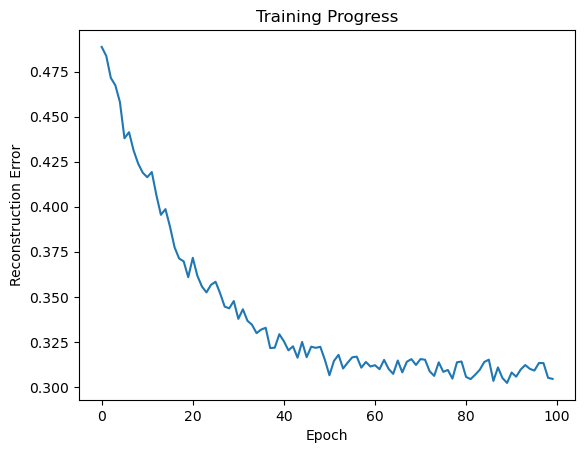

In [145]:
# Generate synthetic data
np.random.seed(42)
data = np.zeros((1000, 10))
data[:, :5] = np.random.binomial(1, 0.8, (1000, 5))
data[:, 5:] = np.random.binomial(1, 0.2, (1000, 5))

# Initialize and train RBM
rbm = RBM(10, 5)
rbm.fit(data,
          nb_epoch=100,
          batch_size=128,
          lr=0.01,
          verbose=False)

# Plot losses
rbm.plot_losses()

### 2.2 Weight Visualization
Observe how weights connect correlated units:

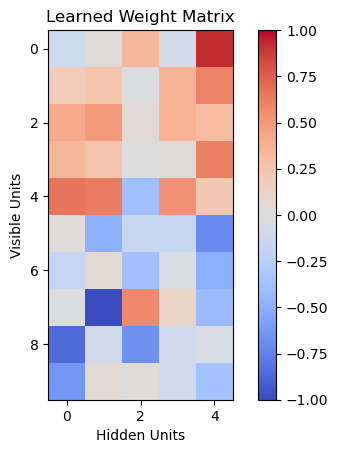

In [146]:
plt.imshow(rbm.W, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Learned Weight Matrix")
plt.xlabel("Hidden Units")
plt.ylabel("Visible Units")
plt.show()

**Interpretation**:
- Strong positive weights (red) between first 5 visible units and hidden units
- Near-zero weights (white) for uncorrelated units

## 3. MNIST Feature Learning

### 3.1 Data Preparation

**Data Preparation**:
- 28x28 binary images of handwritten digits
- 60,000 training examples
- Goal: Learn stroke detectors

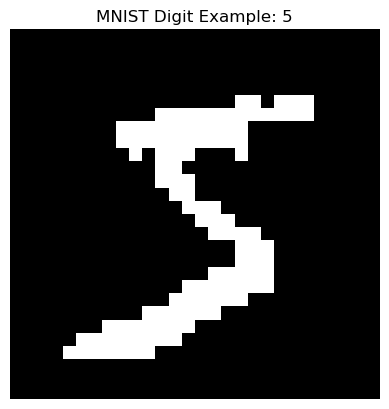

In [12]:
# Load and binarize MNIST
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = Binarizer(threshold=0.5).fit_transform(X / 255)
#X = (X / 255 > np.random.rand(*X.shape)).astype(int)

# Convertir les labels en entiers
y = y.astype(int)

# Diviser en ensembles d'entraînement et de test
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

# Visualiser un exemple
plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
plt.title(f"MNIST Digit Example: {y_train[0]}")
plt.axis('off')
plt.show()

### 3.2 Training Process

Implement mini-batch training:

**Training Insights**:
- Each hidden unit learns a "receptive field"
- We visualize weights as 28x28 images
- Expect to see stroke/digit part detectors

- We expect a 10% error rate (20% is way too much)

In [147]:
# Train RBM on MNIST
rbm_mnist = RBM(784, 256)
rbm_mnist.fit(X_train,
                nb_epoch=20,
                batch_size=100,
                lr=0.1)

Epoch 1: Error 0.0931
Epoch 2: Error 0.0650
Epoch 3: Error 0.0572
Epoch 4: Error 0.0526
Epoch 5: Error 0.0493
Epoch 6: Error 0.0469
Epoch 7: Error 0.0449
Epoch 8: Error 0.0433
Epoch 9: Error 0.0419
Epoch 10: Error 0.0407
Epoch 11: Error 0.0398
Epoch 12: Error 0.0389
Epoch 13: Error 0.0382
Epoch 14: Error 0.0375
Epoch 15: Error 0.0370
Epoch 16: Error 0.0364
Epoch 17: Error 0.0359
Epoch 18: Error 0.0355
Epoch 19: Error 0.0351
Epoch 20: Error 0.0347


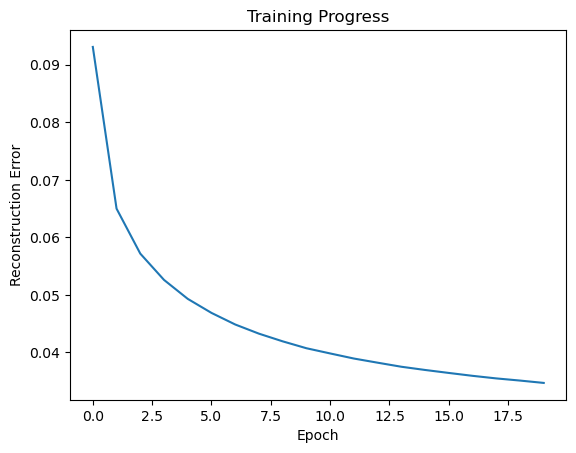

In [148]:
rbm_mnist.plot_losses()

### 3.3 Feature Visualization
Visualize learned hidden unit weights:

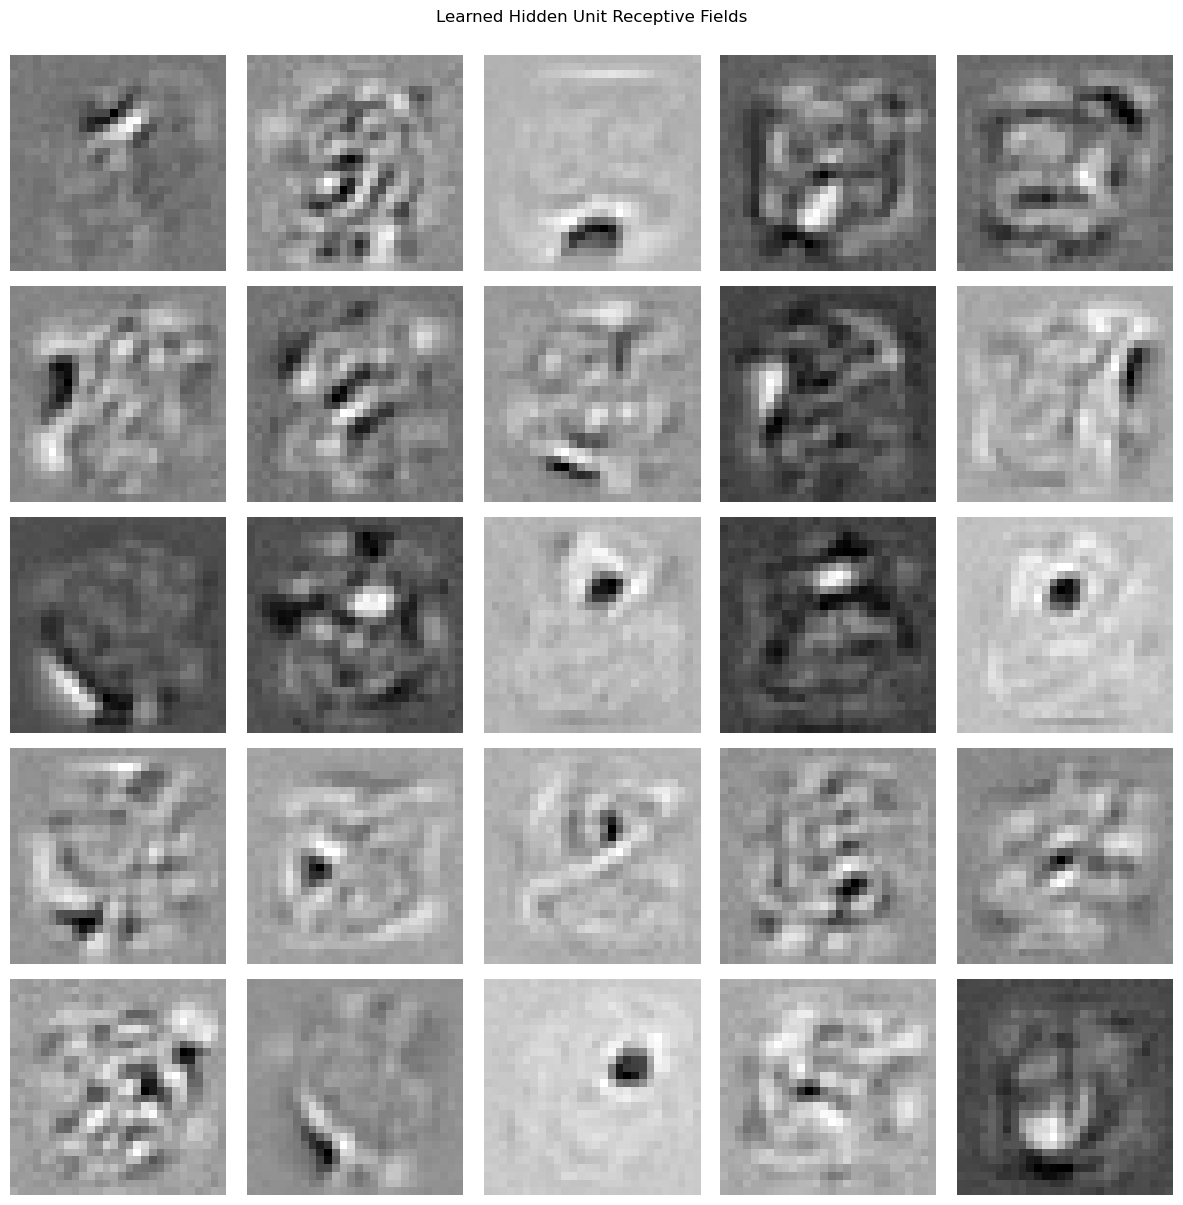

In [149]:
rbm_mnist.plot_weights(n=25)

**Observation**:
- Units learn stroke detectors and digit part detectors
- Emergence of Gabor-like filters for edge detection

### 3.4 Reconstruction Process
Demonstrate Gibbs sampling steps:

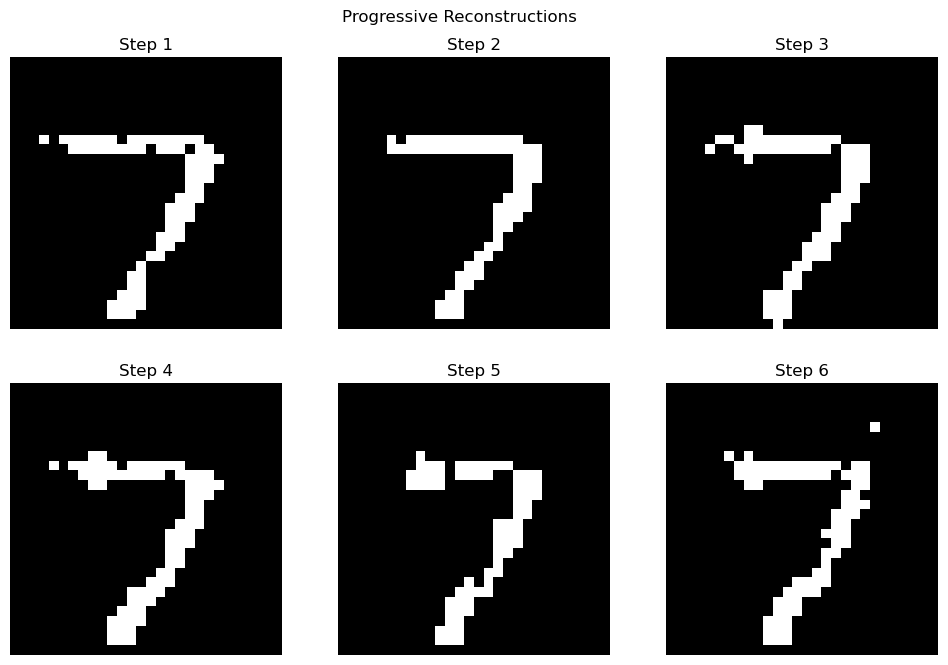

In [150]:
rbm_mnist.reconstruct(X_test[0], nb_iter_gibbs=6)

### 3.5 Prediction and Evaluation

In [ ]:
# Prédiction et évaluation
test_error = rbm_mnist.evaluate(X_test, binary=False)
print(f"Test Reconstruction Error: {test_error:.4f}")

Test Reconstruction Error: 0.0118


## 4. Advanced Concepts

### 4.1 Persistent Contrastive Divergence
Implementation of PCD with persistent chains:
- Maintains Markov chains between updates
- Better approximation of model expectations
- Particularly useful for small learning rates

In [56]:
class PersistentRBM(RBM):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.persistent_chain = None
        
    def pcd_step(self, v, k=1):
        if self.persistent_chain is None:
            self.persistent_chain = np.random.randint(0, 2, (v.shape[0], self.n_hidden))
        
        # Positive phase
        p_h_pos, _ = self.sample_hidden(v)
        
        # Negative phase
        for _ in range(k):
            _, self.persistent_chain = self.sample_hidden(self.persistent_chain)
        
        # Update parameters
        grad_W = (np.dot(v.T, p_h_pos) - np.dot(self.persistent_chain.T, self.persistent_chain)) / v.shape[0]
        self.W += self.lr * grad_W
        
        return np.mean((v - self.persistent_chain) ** 2)

### 4.2 Temperature Parameter
Modified energy function with temperature:

$$
E_T(v,h) = \frac{1}{T}E(v,h)
$$
Implementation:

In [60]:
class TRBM(RBM):
    def __init__(self, temp=1.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.T = temp
        
    def sample_hidden(self, v):
        activation = (np.dot(v, self.W) + self.b) / self.T
        p_h = self._sigmoid(activation)
        return p_h, (np.random.rand(*p_h.shape) < p_h).astype(float)
    
    def sample_visible(self, h):
        activation = (np.dot(h, self.W.T) + self.a) / self.T
        p_v = self._sigmoid(activation)
        return p_v, (np.random.rand(*p_v.shape) < p_v).astype(float)

## 5. Practical Recommendations

### 5.1 Hyperparameter Tuning Guide

| Parameter      | Typical Range     | Effect                                                                 |
|----------------|-------------------|-----------------------------------------------------------------------|
| Learning Rate  | 0.01-0.1          | Higher: faster learning but unstable; Lower: stable but slow         |
| Hidden Units   | 50-500            | More: higher capacity but overfitting risk                           |
| Batch Size     | 10-100            | Smaller: noisy gradients; Larger: smoother but memory intensive      |
| CD Steps (k)   | 1-10              | More: better approximation but slower                                |

### 5.2 Debugging Tips
1. **Check Reconstruction Error**: Should decrease monotonically
2. **Visualize Weights**: Look for dead units (all weights zero)
3. **Monitor Gradient Magnitudes**: Should stabilize over time
4. **Try Different Initializations**: Xavier initialization often helps

### 5.3 Comparison with Autoencoders

| Feature              | RBM                     | Autoencoder               |
|----------------------|-------------------------|---------------------------|
| Training             | Contrastive Divergence  | Backpropagation           |
| Probabilistic        | Yes                     | No                        |
| Generative           | Yes                     | Usually no                |
| Feature Type         | Binary                  | Continuous                |

## 6. Experimental Section

Try these experiments in order:

1. **Vary Hidden Units**: Compare reconstructions with 64 vs 256 hidden units
2. **Adjust Learning Rate**: Try 0.01 vs 0.1, observe convergence speed
3. **Change CD Steps**: Compare k=1 vs k=5 sampling steps
4. **Add Noise**: Train with noisy inputs to improve robustness

## 7. Comparison with scikit-learn's BernoulliRBM
### Key Differences:
| Feature                | Our Implementation       | scikit-learn's BernoulliRBM |
|------------------------|--------------------------|------------------------------|
| Training Algorithm     | CD-1                     | CD-1 (default)               |
| Performance            | Educational              | Optimized C++ extensions     |
| Persistence            | Manual saving            | scikit-learn estimator API   |
| Features               | Basic functionality      | Integration with scikit-learn|
| Customization          | Full code access         | Limited parameters           |
### 7.1 Side-by-Side Implementation

In [ ]:
# scikit-learn RBM
sklearn_rbm = BernoulliRBM(
    n_components=256,
    learning_rate=0.1,
    batch_size=100,
    n_iter=20,
    random_state=42
)

sklearn_rbm.fit(X_train);

### 7.2 Feature Comparison
Visualize features learned by both implementations:

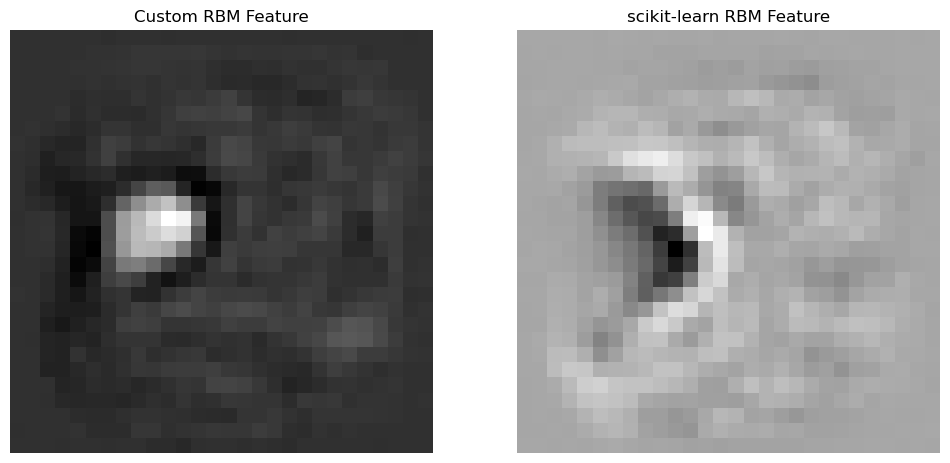

In [67]:
plt.figure(figsize=(12,6))

# Custom RBM features
plt.subplot(1,2,1)
plt.imshow(rbm.W[:,0].reshape(28,28), cmap='gray')
plt.title("Custom RBM Feature")
plt.axis('off')

# scikit-learn features
plt.subplot(1,2,2)
plt.imshow(sklearn_rbm.components_[0].reshape(28,28), cmap='gray')
plt.title("scikit-learn RBM Feature")
plt.axis('off')

plt.show()

### 7.3 Reconstruction Comparison
Compare reconstruction capabilities:

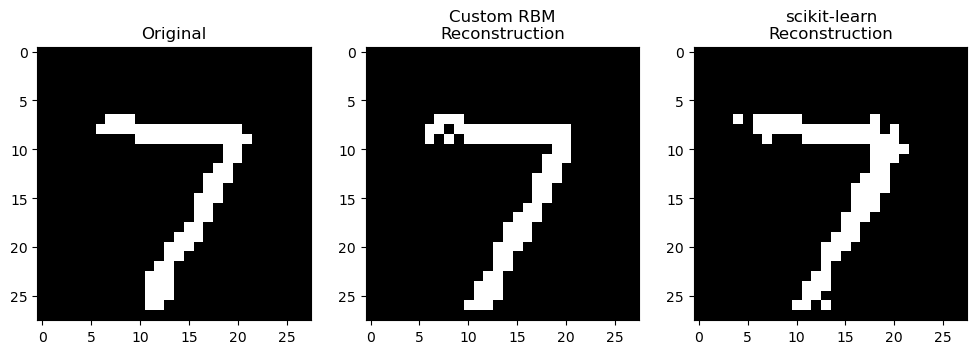

In [68]:
test_image = X_test[0].reshape(1,-1)

# Custom RBM reconstruction
_, h = rbm.sample_hidden(test_image)
_, custom_recon = rbm.sample_visible(h)

# scikit-learn reconstruction
sklearn_recon = sklearn_rbm.gibbs(test_image)

# Plot comparisons
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(test_image.reshape(28,28), cmap='gray')
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(custom_recon.reshape(28,28), cmap='gray')
plt.title("Custom RBM\nReconstruction")

plt.subplot(1,3,3)
plt.imshow(sklearn_recon.reshape(28,28), cmap='gray')
plt.title("scikit-learn\nReconstruction")

plt.show()

### 7.4 Performance Benchmark
Compare training speed and reconstruction error:

In [70]:
import time

def benchmark_rbm(rbm, X, name):
    start = time.time()
    if hasattr(rbm, 'fit'):
        rbm.fit(X)
    else:
        for _ in range(10):
            rbm.contrastive_divergence(X)
    elapsed = time.time() - start
    
    # Compute reconstruction error
    if name == "Custom":
        _, h = rbm.sample_hidden(X)
        p_v, _ = rbm.sample_visible(h)
    else:
        p_v = rbm.gibbs(X)
    
    mse = np.mean((X - p_v) ** 2)
    print(f"{name} RBM:\n- Time: {elapsed:.2f}s\n- MSE: {mse:.4f}\n")

benchmark_rbm(rbm, X_train[:1000], "Custom")
benchmark_rbm(sklearn_rbm, X_train[:1000], "scikit-learn")

Custom RBM:
- Time: 0.77s
- MSE: 0.0151

scikit-learn RBM:
- Time: 2.50s
- MSE: 0.1017



### 7.5 When to Use Which?

**Choose Custom Implementation When**:
- You need to modify the core algorithm
- Educational purposes
- Research prototypes

**Choose scikit-learn When**:
- Production applications
- Integration with other scikit-learn components
- Need optimized performance
- Standard RBM functionality is sufficient

## 8. Conclusion & Resources

**Key Takeaways**:
- RBMs learn probabilistic binary features through energy minimization
- Training uses contrastive divergence as tractable approximation
- Hidden units discover meaningful data representations

**Further Reading**:
- [Hinton's Guide to Training RBMs](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)
- [Deep Learning Book Chapter 20](https://www.deeplearningbook.org/contents/boltzmann.html)
- [Persistent Contrastive Divergence Paper](https://www.cs.toronto.edu/~tijmen/pcd/pcd.pdf)

**Final Code Test**:
Run this cell to verify your implementation:

In [42]:
def rbm_smoketest():
    """Verify basic RBM functionality"""
    model = RBM(5, 2)
    model.lr = 0.1
    data = np.random.randint(0, 2, (10, 5))
    
    # Test sampling
    p_h, h = model.sample_hidden(data)
    assert p_h.shape == (10, 2), "Hidden sampling shape mismatch"
    
    # Test CD step
    error = model.contrastive_divergence(data)
    assert error.dtype == np.float64, "Error should be scalar"
    
    print("All basic tests passed!")

rbm_smoketest()

All basic tests passed!


## 9. DBN

In [13]:
class DBN:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes  # [visible_size, hidden1_size, ..., hiddenN_size]
        self.rbms = [
            RBM(layer_sizes[i], layer_sizes[i+1]) 
            for i in range(len(layer_sizes)-1)
        ]
        self.trained = False
        self.pretrain_errors = []

    def fit(self, data, nb_epochs=10, batch_size=100, lr=0.01, k=1,
            momentum=0.0, weight_decay=0.0, l1_reg=0.0, decay_rate=1.0, verbose=True):
        self.trained = True
        input_data = data.copy()
        for i, rbm in enumerate(self.rbms):
            print(f"Prétraining couche {i+1}/{len(self.rbms)}...")
            rbm.fit(input_data, nb_epochs, batch_size, lr, k,
                    momentum, weight_decay, l1_reg, decay_rate, verbose)
            self.pretrain_errors.append(rbm.losses)
            p_h, _ = rbm.sample_hidden(input_data)
            input_data = p_h
        return self
    
    def transform(self, X):
        hidden = X.copy()
        for rbm in self.rbms:
            hidden = rbm.transform(hidden)
        return hidden

    def predict(self, X):
        # Monte à travers les couches
        hidden = X.copy()
        for rbm in self.rbms:
            hidden = rbm.transform(hidden)
        
        # Descend à travers les couches
        for i in reversed(range(len(self.rbms))):
            p_v, _ = self.rbms[i].sample_visible(hidden)
            hidden = p_v
        return hidden
    
    def evaluate(self, X):
        reconstructions = self.predict(X)
        return np.mean((X - reconstructions) ** 2)
    
    def plot_pretraining_errors(self):
        plt.figure(figsize=(10, 6))
        for i, errors in enumerate(self.pretrain_errors):
            plt.plot(errors, label=f'Couche {i+1}')
        plt.title("Erreurs de prétraining par couche")
        plt.xlabel("Epoch")
        plt.ylabel("Erreur de reconstruction")
        plt.legend()
        plt.show()

In [ ]:
# Création et entraînement du DBN
dbn = DBN(layer_sizes=[784, 500, 200])  # 784 -> 500 -> 200
dbn.fit(X_train, 
        nb_epochs=50, 
        batch_size=100,
        lr=0.1,
        momentum=0.9,
        weight_decay=0.0001,
        decay_rate=1.0,
        verbose=True)

Prétraining couche 1/2...
Epoch 1/50: Error 0.0697
Epoch 2/50: Error 0.0470
Epoch 3/50: Error 0.0415
Epoch 4/50: Error 0.0386
Epoch 5/50: Error 0.0369
Epoch 6/50: Error 0.0356
Epoch 7/50: Error 0.0347
Epoch 8/50: Error 0.0339
Epoch 9/50: Error 0.0333
Epoch 10/50: Error 0.0327
Epoch 11/50: Error 0.0323
Epoch 12/50: Error 0.0318
Epoch 13/50: Error 0.0315
Epoch 14/50: Error 0.0312
Epoch 15/50: Error 0.0309
Epoch 16/50: Error 0.0306
Epoch 17/50: Error 0.0304
Epoch 18/50: Error 0.0302
Epoch 19/50: Error 0.0300
Epoch 20/50: Error 0.0298
Epoch 21/50: Error 0.0297
Epoch 22/50: Error 0.0295
Epoch 23/50: Error 0.0293
Epoch 24/50: Error 0.0292
Epoch 25/50: Error 0.0290
Epoch 26/50: Error 0.0289
Epoch 27/50: Error 0.0288
Epoch 28/50: Error 0.0287
Epoch 29/50: Error 0.0285
Epoch 30/50: Error 0.0285
Epoch 31/50: Error 0.0284
Epoch 32/50: Error 0.0283
Epoch 33/50: Error 0.0282
Epoch 34/50: Error 0.0281
Epoch 35/50: Error 0.0281
Epoch 36/50: Error 0.0280
Epoch 37/50: Error 0.0279
Epoch 38/50: Error 0.

In [14]:
# Création et entraînement du DBN
dbn = DBN(layer_sizes=[784, 500, 1000, 2000])  # 784 -> 500 -> 500 -> 2000
dbn.fit(X_train, 
        nb_epochs=100,
        batch_size=100,
        lr=0.1,
        verbose=True)

Prétraining couche 1/3...
Epoch 1/100: Error 0.0836
Epoch 2/100: Error 0.0558
Epoch 3/100: Error 0.0478
Epoch 4/100: Error 0.0432
Epoch 5/100: Error 0.0400
Epoch 6/100: Error 0.0371
Epoch 7/100: Error 0.0316
Epoch 8/100: Error 0.0292
Epoch 9/100: Error 0.0279
Epoch 10/100: Error 0.0270
Epoch 11/100: Error 0.0264
Epoch 12/100: Error 0.0258
Epoch 13/100: Error 0.0254
Epoch 14/100: Error 0.0250
Epoch 15/100: Error 0.0248
Epoch 16/100: Error 0.0245
Epoch 17/100: Error 0.0243
Epoch 18/100: Error 0.0241
Epoch 19/100: Error 0.0239
Epoch 20/100: Error 0.0238
Epoch 21/100: Error 0.0236
Epoch 22/100: Error 0.0235
Epoch 23/100: Error 0.0234
Epoch 24/100: Error 0.0234
Epoch 25/100: Error 0.0232
Epoch 26/100: Error 0.0232
Epoch 27/100: Error 0.0230
Epoch 28/100: Error 0.0230
Epoch 29/100: Error 0.0229
Epoch 30/100: Error 0.0228
Epoch 31/100: Error 0.0227
Epoch 32/100: Error 0.0227
Epoch 33/100: Error 0.0227
Epoch 34/100: Error 0.0226
Epoch 35/100: Error 0.0226
Epoch 36/100: Error 0.0225
Epoch 37/10

In [271]:
# Évaluation
train_error = dbn.evaluate(X_train[:1000])
test_error = dbn.evaluate(X_test[:1000])
print(f"Train error: {train_error:.4f}, Test error: {test_error:.4f}")

Train error: 0.0179, Test error: 0.0206


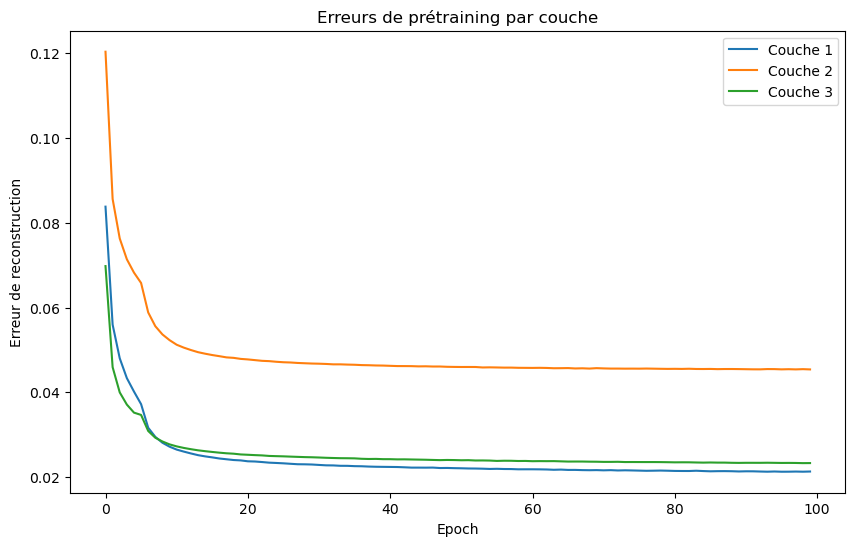

In [272]:
# Visualisation
dbn.plot_pretraining_errors()

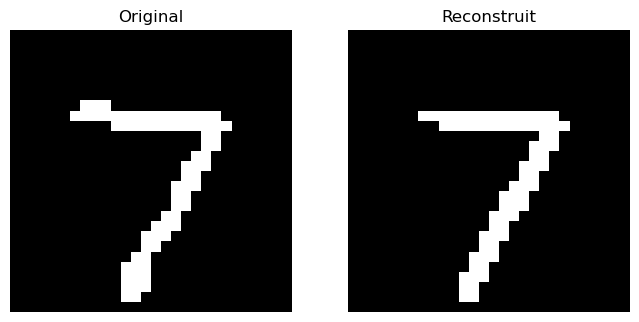

In [273]:
# Reconstruction d'exemple
sample = X_test[0]
reconstructed = (dbn.predict(sample.reshape(1, -1)) > 0.5).astype(int)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample.reshape(28, 28), cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed.reshape(28, 28), cmap='gray')
plt.title("Reconstruit")
plt.axis('off')
plt.show()

## 10. DNN pretrained with DBN

In [15]:
def xavier_init(fan_in, fan_out):
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

class DNN:
    def __init__(self, layer_sizes, dbn=None):
        self.layer_sizes = layer_sizes
        self.weights = []
        self.biases = []

        if dbn:
            # Initialiser les poids et biais à partir du DBN
            for rbm in dbn.rbms:
                self.weights.append(rbm.W.copy())
                self.biases.append(rbm.b.copy())
            # Ajouter la couche finale pour la classification
            #self.weights.append(np.random.randn(layer_sizes[-2], layer_sizes[-1]) * 0.01)
            self.weights.append(xavier_init(layer_sizes[-2], layer_sizes[-1]))
            self.biases.append(np.zeros(layer_sizes[-1]))
            
        else:
            # Initialisation aléatoire si pas de DBN fourni
            for i in range(len(layer_sizes) - 1):
                self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01)
                self.biases.append(np.zeros(layer_sizes[i + 1]))

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

    def forward(self, X):
        activations = [X]
        for W, b in zip(self.weights[:-1], self.biases[:-1]):
            X = self.sigmoid(np.dot(X, W) + b)
            activations.append(X)
        
        # Dernière couche avec softmax
        logits = np.dot(X, self.weights[-1]) + self.biases[-1]
        activations.append(self.softmax(logits))
        return activations

    def backward(self, activations, y_true, lr, reg_lambda=0.0):
        deltas = [activations[-1] - y_true]

        # Calculer les gradients pour les couches cachées
        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * activations[i] * (1 - activations[i])
            deltas.insert(0, delta)

        # Mise à jour des poids et biais
        for i in range(len(self.weights)):
            grad_W = np.dot(activations[i].T, deltas[i]) / y_true.shape[0]
            grad_b = np.mean(deltas[i], axis=0)
            
            # Ajouter la pénalité de régularisation L2
            grad_W += reg_lambda * self.weights[i]
            
            # Mettre à jour les poids et biais
            self.weights[i] -= lr * grad_W
            self.biases[i] -= lr * grad_b

    def fit(self, X_train, y_train, X_val=None, y_val=None, nb_epochs=10, batch_size=100,
            lr=0.01, decay_rate=1.0, reg_lambda=0.0, verbose=True):
        history = []
        initial_lr = lr
        for epoch in range(nb_epochs):
            
            # Appliquer la décroissance du taux d'apprentissage
            if epoch > 20:
                lr = initial_lr * (decay_rate ** epoch)
            # Mélanger les données
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            # Diviser en mini-batches
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]

                activations = self.forward(X_batch)
                self.backward(activations, y_batch, lr, reg_lambda)

            # Calculer la perte sur l'ensemble d'entraînement
            train_loss = self.cross_entropy_loss(y_train, self.forward(X_train)[-1])

            if X_val is not None and y_val is not None:
                val_loss = self.cross_entropy_loss(y_val, self.forward(X_val)[-1])
                if verbose:
                    print(f"Epoch {epoch+1}/{nb_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
                history.append((train_loss, val_loss))
            else:
                if verbose:
                    print(f"Epoch {epoch+1}/{nb_epochs} - Train Loss: {train_loss:.4f}")
                history.append(train_loss)

        return history

    def predict(self, X):
        probs = self.forward(X)[-1]
        return np.argmax(probs, axis=1)

    def accuracy(self, X, y_true):
        y_pred = self.predict(X)
        return np.mean(y_pred == np.argmax(y_true, axis=1))
    
    def error_rate(self, X, y_true):
        return 1 - self.accuracy(X, y_true)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

In [17]:
# Conversion des labels en numpy array
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

# One-hot encoding des labels
encoder = OneHotEncoder(sparse_output=False)  # Utiliser sparse_output pour les versions récentes
y_train_onehot = encoder.fit_transform(y_train_array.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test_array.reshape(-1, 1))

# Vérifiez la forme des données
print(f"y_train shape (one-hot): {y_train_onehot.shape}")
print(f"y_test shape (one-hot): {y_test_onehot.shape}")

y_train shape (one-hot): (60000, 10)
y_test shape (one-hot): (10000, 10)


In [255]:
# Exemple avec MNIST
dnn = DNN(layer_sizes=[784, 500, 200, 10], dbn=dbn)
dnn.fit(X_train, y_train_onehot, X_val=X_test, y_val=y_test_onehot,
        nb_epochs=50, batch_size=100, lr=0.4, decay_rate=0.98, reg_lambda=0.000011)

Epoch 1/50 - Train Loss: 0.2416 - Val Loss: 0.2260
Epoch 2/50 - Train Loss: 0.1949 - Val Loss: 0.1846
Epoch 3/50 - Train Loss: 0.1678 - Val Loss: 0.1626
Epoch 4/50 - Train Loss: 0.1504 - Val Loss: 0.1492
Epoch 5/50 - Train Loss: 0.1369 - Val Loss: 0.1395
Epoch 6/50 - Train Loss: 0.1259 - Val Loss: 0.1318
Epoch 7/50 - Train Loss: 0.1159 - Val Loss: 0.1246
Epoch 8/50 - Train Loss: 0.1081 - Val Loss: 0.1196
Epoch 9/50 - Train Loss: 0.1015 - Val Loss: 0.1161
Epoch 10/50 - Train Loss: 0.0953 - Val Loss: 0.1140
Epoch 11/50 - Train Loss: 0.0894 - Val Loss: 0.1104
Epoch 12/50 - Train Loss: 0.0837 - Val Loss: 0.1061
Epoch 13/50 - Train Loss: 0.0792 - Val Loss: 0.1042
Epoch 14/50 - Train Loss: 0.0747 - Val Loss: 0.1013
Epoch 15/50 - Train Loss: 0.0710 - Val Loss: 0.1000
Epoch 16/50 - Train Loss: 0.0671 - Val Loss: 0.0975
Epoch 17/50 - Train Loss: 0.0635 - Val Loss: 0.0967
Epoch 18/50 - Train Loss: 0.0607 - Val Loss: 0.0952
Epoch 19/50 - Train Loss: 0.0580 - Val Loss: 0.0945
Epoch 20/50 - Train L

[(0.2415982399770244, 0.22598636967756952),
 (0.1949308344925518, 0.18462283281623587),
 (0.16783901509152657, 0.16264613593832575),
 (0.15039272452052962, 0.14920194059977918),
 (0.1368541496165202, 0.1394786858550738),
 (0.12593547227273064, 0.131838401165035),
 (0.11592882354782344, 0.12463411751422585),
 (0.10812055946209781, 0.11957760157002267),
 (0.10150270284471072, 0.11610240308217426),
 (0.095309260277703, 0.11403438263663147),
 (0.08944673845170865, 0.11042362454833435),
 (0.0837317540291167, 0.10610756506453542),
 (0.07922619663352994, 0.10421438550485485),
 (0.07470239446113393, 0.10130591055240584),
 (0.07099251474226922, 0.10003061919538998),
 (0.0671020344750389, 0.0974757333464595),
 (0.0635441471852215, 0.09665272674939726),
 (0.060734660980865204, 0.0952254571333346),
 (0.058028064279594595, 0.0945175715125559),
 (0.05500039284640811, 0.09266322871005613),
 (0.05236604710406796, 0.09173419591455637),
 (0.05075953536364318, 0.09044377936849607),
 (0.049354996938322, 0

In [276]:
# Exemple avec MNIST
dnn = DNN(layer_sizes=[784, 500, 500, 2000, 10], dbn=dbn)
dnn.fit(X_train, y_train_onehot, X_val=X_test, y_val=y_test_onehot,
        nb_epochs=100, batch_size=100, lr=0.1)

Epoch 1/100 - Train Loss: 0.2809 - Val Loss: 0.2713
Epoch 2/100 - Train Loss: 0.1987 - Val Loss: 0.1928
Epoch 3/100 - Train Loss: 0.1649 - Val Loss: 0.1610
Epoch 4/100 - Train Loss: 0.1450 - Val Loss: 0.1428
Epoch 5/100 - Train Loss: 0.1313 - Val Loss: 0.1300
Epoch 6/100 - Train Loss: 0.1211 - Val Loss: 0.1208
Epoch 7/100 - Train Loss: 0.1131 - Val Loss: 0.1138
Epoch 8/100 - Train Loss: 0.1066 - Val Loss: 0.1082
Epoch 9/100 - Train Loss: 0.1011 - Val Loss: 0.1035
Epoch 10/100 - Train Loss: 0.0964 - Val Loss: 0.0994
Epoch 11/100 - Train Loss: 0.0923 - Val Loss: 0.0960
Epoch 12/100 - Train Loss: 0.0888 - Val Loss: 0.0931
Epoch 13/100 - Train Loss: 0.0855 - Val Loss: 0.0903
Epoch 14/100 - Train Loss: 0.0826 - Val Loss: 0.0879
Epoch 15/100 - Train Loss: 0.0800 - Val Loss: 0.0858
Epoch 16/100 - Train Loss: 0.0775 - Val Loss: 0.0838
Epoch 17/100 - Train Loss: 0.0753 - Val Loss: 0.0820
Epoch 18/100 - Train Loss: 0.0732 - Val Loss: 0.0805
Epoch 19/100 - Train Loss: 0.0713 - Val Loss: 0.0788
Ep

[(0.2808550465099974, 0.27131437545153353),
 (0.19873410570966404, 0.19277967790264788),
 (0.1648568356162459, 0.16102406867382624),
 (0.1450191267185061, 0.14280022486186633),
 (0.13134737474154418, 0.1300486342314769),
 (0.12111961353374426, 0.12083318035238763),
 (0.11314451349658763, 0.11384830715250523),
 (0.10658591968050625, 0.10821674416655269),
 (0.10109233045403485, 0.1034506225763353),
 (0.09641437450150554, 0.0994105569781808),
 (0.09231321782651583, 0.09600277222712474),
 (0.08880211571671798, 0.09310071179276679),
 (0.08550662119010533, 0.09031958802419375),
 (0.08259068222382725, 0.087881437581374),
 (0.07997119665506172, 0.0858352088912028),
 (0.07751691022735285, 0.0838094347151265),
 (0.0752881888711136, 0.08200742525943826),
 (0.07324254741725358, 0.08046558784039422),
 (0.0713177092656923, 0.07878888565528173),
 (0.0695106677405316, 0.07752241647412635),
 (0.06783761471566684, 0.07637550215622385),
 (0.06630483216234632, 0.07500538984708109),
 (0.06475213425523246, 

In [18]:
# Exemple avec MNIST
dnn = DNN(layer_sizes=[784, 500, 1000, 2000, 10], dbn=dbn)
dnn.fit(X_train, y_train_onehot, X_val=X_test, y_val=y_test_onehot,
        nb_epochs=100, batch_size=100, lr=0.1)

Epoch 1/100 - Train Loss: 0.2623 - Val Loss: 0.2531
Epoch 2/100 - Train Loss: 0.1877 - Val Loss: 0.1813
Epoch 3/100 - Train Loss: 0.1563 - Val Loss: 0.1516
Epoch 4/100 - Train Loss: 0.1383 - Val Loss: 0.1345
Epoch 5/100 - Train Loss: 0.1252 - Val Loss: 0.1226
Epoch 6/100 - Train Loss: 0.1156 - Val Loss: 0.1143
Epoch 7/100 - Train Loss: 0.1081 - Val Loss: 0.1074
Epoch 8/100 - Train Loss: 0.1020 - Val Loss: 0.1019
Epoch 9/100 - Train Loss: 0.0970 - Val Loss: 0.0978
Epoch 10/100 - Train Loss: 0.0925 - Val Loss: 0.0945
Epoch 11/100 - Train Loss: 0.0885 - Val Loss: 0.0910
Epoch 12/100 - Train Loss: 0.0852 - Val Loss: 0.0878
Epoch 13/100 - Train Loss: 0.0821 - Val Loss: 0.0858
Epoch 14/100 - Train Loss: 0.0792 - Val Loss: 0.0834
Epoch 15/100 - Train Loss: 0.0767 - Val Loss: 0.0815
Epoch 16/100 - Train Loss: 0.0742 - Val Loss: 0.0795
Epoch 17/100 - Train Loss: 0.0721 - Val Loss: 0.0781
Epoch 18/100 - Train Loss: 0.0701 - Val Loss: 0.0765
Epoch 19/100 - Train Loss: 0.0685 - Val Loss: 0.0752
Ep

[(0.26225162630614063, 0.25309008403380073),
 (0.187698234795645, 0.1812838759989581),
 (0.1562816006411812, 0.15164951370549765),
 (0.13833976907373666, 0.13453053577425758),
 (0.12522508389156187, 0.12260238658772317),
 (0.11563210920763353, 0.11434600985546887),
 (0.10813498222698957, 0.10739797105887935),
 (0.10198978009229967, 0.10194151400356748),
 (0.0970065942234317, 0.09779563360984016),
 (0.09253858439282495, 0.09446013123994651),
 (0.08854719714568786, 0.09100044631281905),
 (0.08517224972304943, 0.08784869512971681),
 (0.08207937574383663, 0.08581081011353026),
 (0.07918047590978576, 0.08336673204634869),
 (0.0766651652086165, 0.08151299594518936),
 (0.07424209076500851, 0.07950271538264367),
 (0.07213774384723927, 0.07813172975687996),
 (0.07009093399816844, 0.07651794146283304),
 (0.06845917900783319, 0.07522154027187533),
 (0.0665994616173449, 0.07358795628591837),
 (0.0648493068578936, 0.07270268999271466),
 (0.06343048111034512, 0.07144008141968598),
 (0.06214401602007

In [19]:
# Évaluation
train_acc = dnn.accuracy(X_train, y_train_onehot)
train_error = dnn.error_rate(X_train, y_train_onehot)
test_acc = dnn.accuracy(X_test, y_test_onehot)
test_error = dnn.error_rate(X_test, y_test_onehot)
print(f"Train Accuracy: {train_acc * 100:.2f}% - Error Rate: {train_error * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}% - Error Rate: {test_error * 100:.2f}%")

Train Accuracy: 99.56% - Error Rate: 0.44%
Test Accuracy: 98.37% - Error Rate: 1.63%
